In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Convolution2D, Deconvolution2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1

# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
nb_conv = 3

batch_size = 100
if K.image_dim_ordering() == 'th':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 20
intermediate_dim = 128
epsilon_std = 1.0
nb_epoch = 25

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Convolution2D(img_chns, 2, 2, border_mode='same', activation='relu')(x)
conv_2 = Convolution2D(nb_filters, 2, 2,
                       border_mode='same', activation='relu',
                       subsample=(2, 2))(conv_1)
conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_2)
conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, nb_filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, nb_filters)
decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2,
                                          output_shape,
                                          border_mode='valid',
                                          subsample=(2, 2),
                                          activation='relu')
decoder_mean_squash = Convolution2D(img_chns, 2, 2, 
                                    border_mode='valid',
                                    activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)


def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss



Using TensorFlow backend.


In [2]:
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
    

def undersample(x):
    f = np.fft.fft2(x, axes=(1,2))
    fs = np.fft.fftshift(f)
    for n in np.arange(img_rows):
        if n%2 != 0:
            fs[:,n,:,:] = 0
    fs = np.fft.fftshift(fs)    
    return np.abs(np.fft.ifft2(fs, axes=(1,2)))

x_train_undersample = undersample(x_train)    
x_test_undersample = undersample(x_test)    

print('x_train.shape:', x_train.shape)

x_train.shape: (60000, 28, 28, 1)


In [3]:
vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

weights = vae.get_weights()

vae.fit(x_train_undersample, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test_undersample, x_test))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (100, 28, 28, 1)      5           input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (100, 14, 14, 64)     320         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (100, 14, 14, 64)     36928       convolution2d_2[0][0]            
___________________________________________________________________________________________

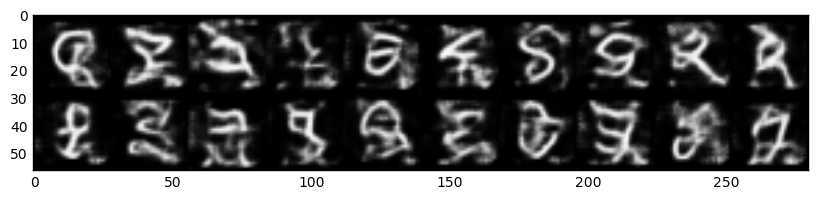

In [4]:
digit_size = 28
row = 2
column = 10
n_tile = int(batch_size/math.gcd(batch_size, latent_dim))
figure_z = np.zeros((digit_size * row, digit_size * column))
z_matrix = np.eye(latent_dim, dtype=int)
z_matrix = np.tile(z_matrix, n_tile)
z_matrix = z_matrix.reshape((int(latent_dim*batch_size/math.gcd(batch_size, latent_dim)), latent_dim))
z_decoded = generator.predict(z_matrix, batch_size=batch_size)
for y in np.arange(row):
    for x in np.arange(column):
        i = y*column+x
        digit = z_decoded[i*n_tile].reshape(digit_size, digit_size)
        figure_z[y * digit_size: (y + 1) * digit_size,
               x * digit_size: (x + 1) * digit_size] = digit
plt.figure(figsize=(10, 4))
plt.imshow(figure_z, cmap='Greys_r')
plt.show()  

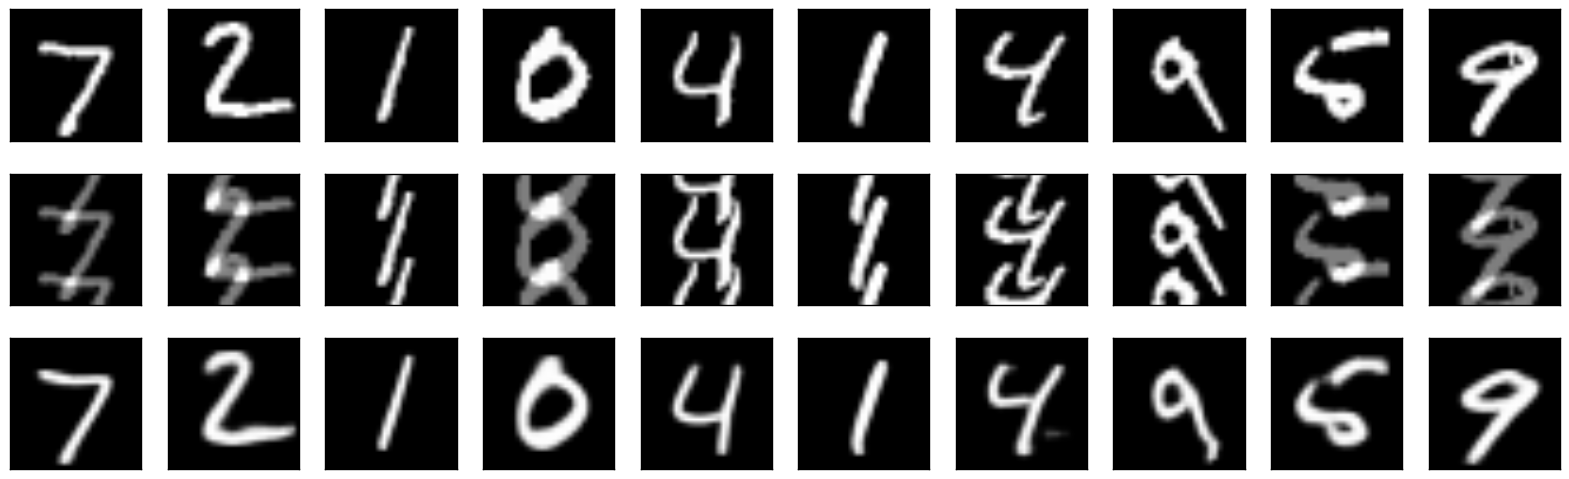

In [6]:
# encode and decode some digits
# note that we take them from the *test* set
recon_imgs_0 = vae.predict(x_test_undersample, batch_size=batch_size)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display undersampled
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_undersample[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)        

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(recon_imgs_0[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [7]:
# another part
def undersample(x):
    f = np.fft.fft2(x, axes=(1,2))
    fs = np.fft.fftshift(f)
    for n in np.arange(img_rows):
        if n%2 != 1:
            fs[:,n,:,:] = 0
    fs = np.fft.fftshift(fs)    
    return np.abs(np.fft.ifft2(fs, axes=(1,2)))

x_train_undersample = undersample(x_train)    
x_test_undersample = undersample(x_test)   

vae.set_weights(weights)

vae.fit(x_train_undersample, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test_undersample, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 17s - loss: 137.1117 - val_loss: 99.7457
Epoch 2/25
60000/60000 [==============================] - 16s - loss: 92.3957 - val_loss: 93.5086
Epoch 3/25
60000/60000 [==============================] - 16s - loss: 83.7897 - val_loss: 79.7329
Epoch 4/25
60000/60000 [==============================] - 16s - loss: 79.6167 - val_loss: 78.7006
Epoch 5/25
60000/60000 [==============================] - 16s - loss: 76.9054 - val_loss: 77.2838
Epoch 6/25
60000/60000 [==============================] - 16s - loss: 74.9735 - val_loss: 75.3664
Epoch 7/25
60000/60000 [==============================] - 16s - loss: 73.4895 - val_loss: 73.9486
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 72.2824 - val_loss: 73.2425
Epoch 9/25
60000/60000 [==============================] - 16s - loss: 71.3024 - val_loss: 73.3049
Epoch 10/25
60000/60000 [==============================] - 16s - lo

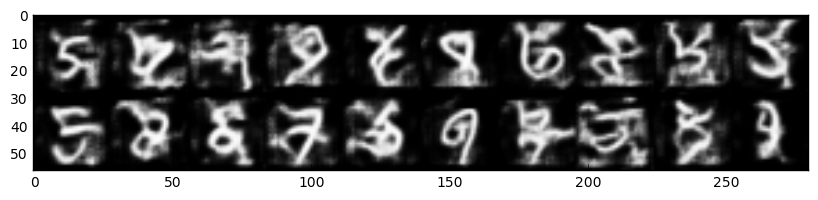

In [8]:
figure_z = np.zeros((digit_size * row, digit_size * column))
z_matrix = np.eye(latent_dim, dtype=int)
z_matrix = np.tile(z_matrix, n_tile)
z_matrix = z_matrix.reshape((int(latent_dim*batch_size/math.gcd(batch_size, latent_dim)), latent_dim))
z_decoded = generator.predict(z_matrix, batch_size=batch_size)
for y in np.arange(row):
    for x in np.arange(column):
        i = y*column+x
        digit = z_decoded[i*n_tile].reshape(digit_size, digit_size)
        figure_z[y * digit_size: (y + 1) * digit_size,
               x * digit_size: (x + 1) * digit_size] = digit
plt.figure(figsize=(10, 4))
plt.imshow(figure_z, cmap='Greys_r')
plt.show()  

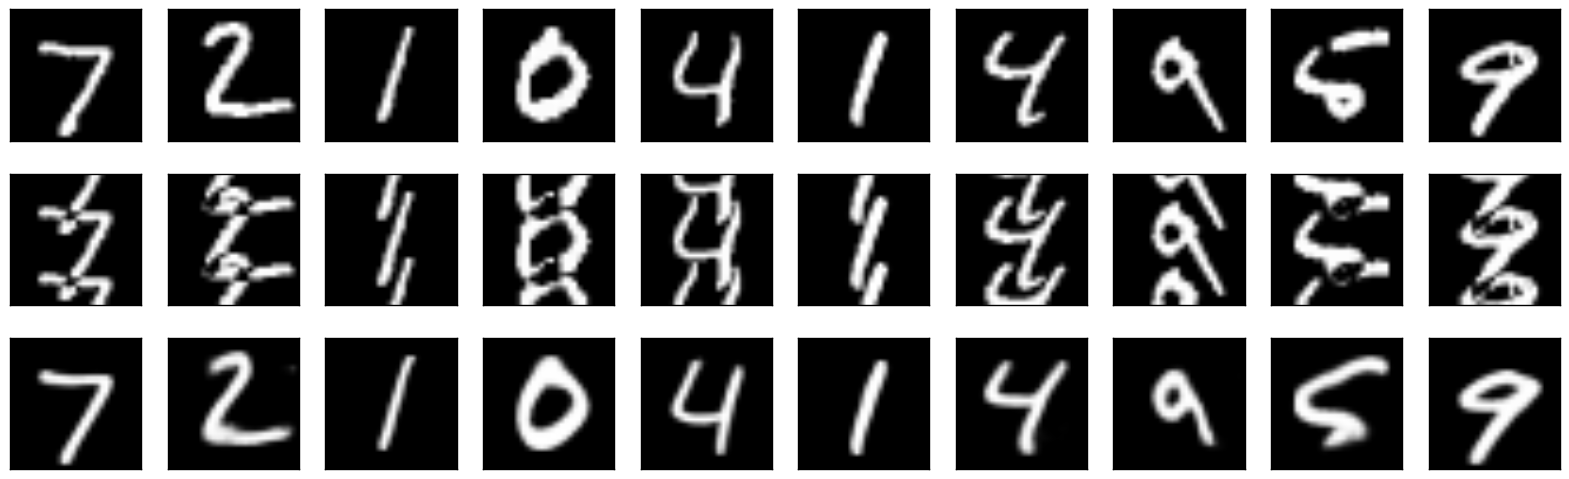

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
recon_imgs_1 = vae.predict(x_test_undersample, batch_size=batch_size)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display undersampled
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_undersample[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)        

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(recon_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

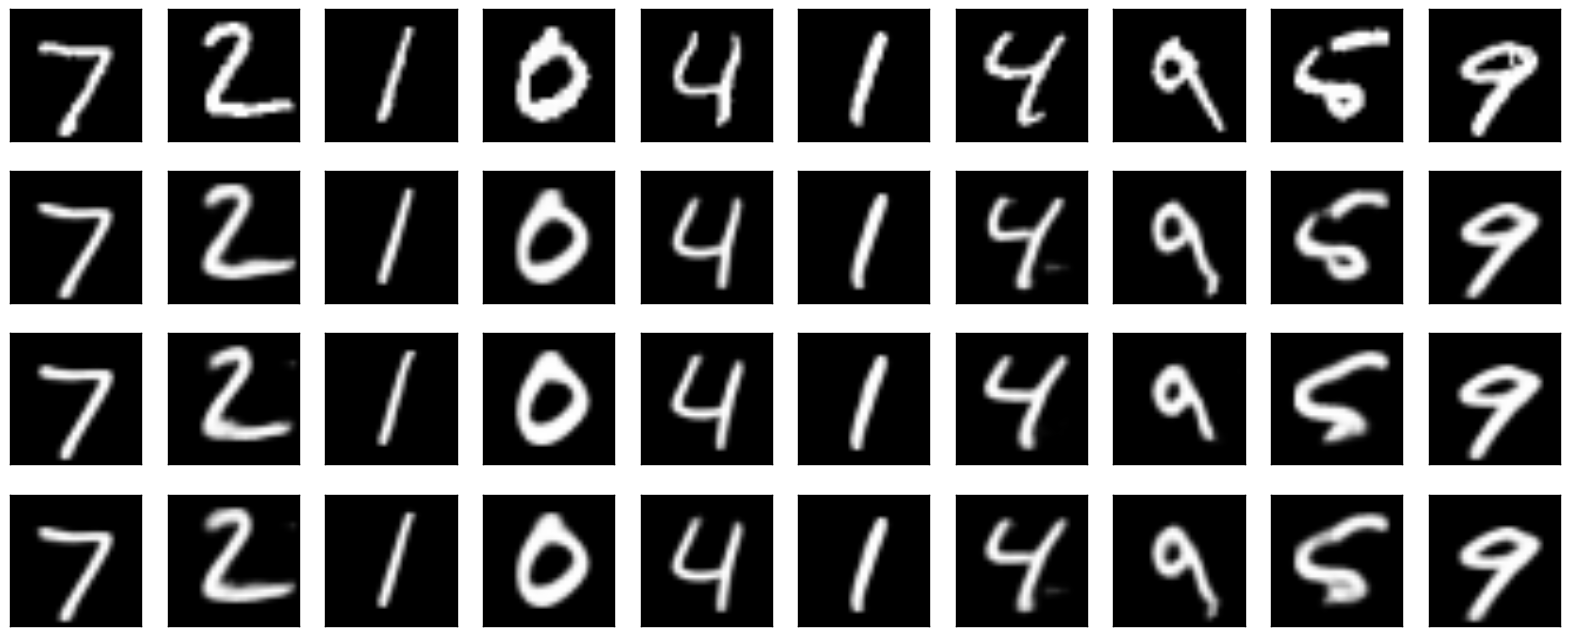

In [10]:
recon_imgs = np.sqrt(recon_imgs_0**2 + recon_imgs_1**2)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction 0
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(recon_imgs_0[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)        

    # display reconstruction 1
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(recon_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display combination
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(recon_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
plt.show()